In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv')

display(train.head())

,image_id,label
0,img_ed005410.jpg,1
1,img_0c5ecd2a.jpg,1
2,img_ed713bb5.jpg,1
3,img_12c58874.jpg,1
4,img_eff357af.jpg,1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


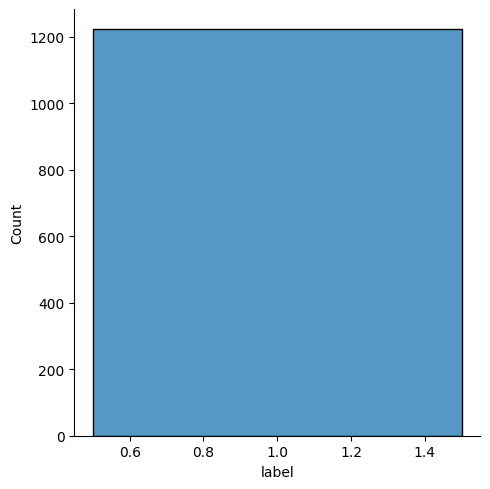

In [3]:
sns.displot(train['label'], kde=False)

In [4]:
train["label"].value_counts()

label
1    1222
Name: count, dtype: int64

In [5]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
TEST_PATH = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'

In [6]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import *
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.foldername = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        folder_name = self.foldername[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image_id']
        return image

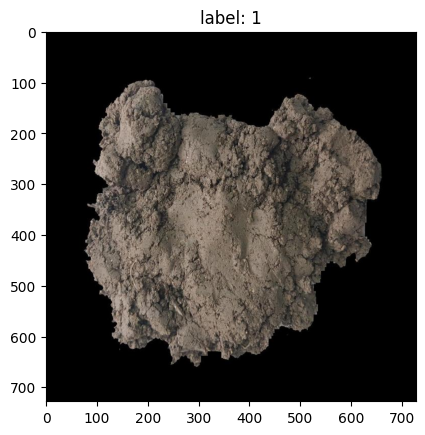

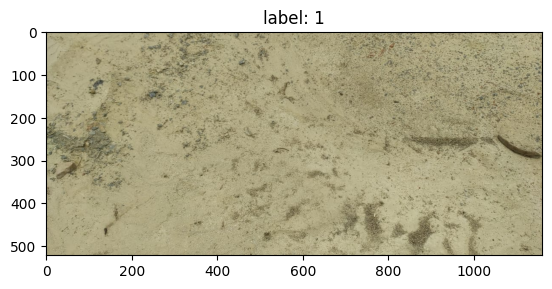

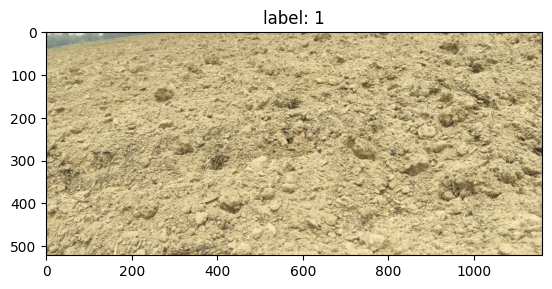

In [8]:
train_dataset = TrainDataset(train, transform=None)

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [9]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b5_ns'  #'resnext50_32x4d'
    size=512
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=8
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='label_encoded'
    n_fold=5
    trn_fold=[0,1,2,3,4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop((CFG.size, CFG.size)),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [11]:
train_dataset = TrainDataset(train, 
                                 transform=get_transforms(data='train'))

In [12]:
train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
import numpy as np

# --------- CONFIGURATION ---------
DATA_DIR = './data'   # Path to your image dataset
BATCH_SIZE = 4        # B5 is large; reduce if you get OOM errors
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
LATENT_DIM = 512
IMAGE_SIZE = 456      # EfficientNet-B5 expects 456x456 images[4][5]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = 'effnetb5_autoencoder.pth'

# --------- DATASET & DATALOADER ---------
weights = EfficientNet_B5_Weights.IMAGENET1K_V1

# --------- AUTOENCODER WITH EFFICIENTNET-B5 BACKBONE ---------
class EffNetB5Autoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        backbone = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)
        self.encoder = backbone.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(backbone.classifier[1].in_features, latent_dim)
        self.relu = nn.ReLU()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        features = self.encoder(x)
        pooled = self.pool(features)
        flat = self.flatten(pooled)
        latent = self.relu(self.fc_latent(flat))
        out = self.decoder(latent)
        if out.shape[-2:] != x.shape[-2:]:
            out = nn.functional.interpolate(out, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return out

# --------- TRAINING FUNCTION (SAVES MODEL) ---------
def train_autoencoder(model, dataloader, num_epochs, lr, device, model_path):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    # Save the model at the end of training
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")



# --------- MAIN ---------
def main():
    print("Loading data...")
    model = EffNetB5Autoencoder(latent_dim=LATENT_DIM)
    print("Training autoencoder...")
    train_autoencoder(model, train_loader, NUM_EPOCHS, LEARNING_RATE, DEVICE, MODEL_PATH)
   
if __name__ == '__main__':
    main()


Loading data...


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 110MB/s]


Training autoencoder...
Epoch [1/10], Loss: 1.4126
Epoch [2/10], Loss: 1.3602
Epoch [3/10], Loss: 1.3663
Epoch [4/10], Loss: 1.3631
Epoch [5/10], Loss: 1.3691
Epoch [6/10], Loss: 1.3716
Epoch [7/10], Loss: 1.3542
Epoch [8/10], Loss: 1.3569
Epoch [9/10], Loss: 1.3681
Epoch [10/10], Loss: 1.3695
Model saved to effnetb5_autoencoder.pth
